In [ ]:
# Logistic Regression: Predicting Titanic Survivors

In [ ]:
# The dataset contains information on passengers who were aboard the Titanic at the time of the disaster (e.g., name, gender, age, ticket number, and so on).
# After applying a logistic-regression model—well-suited when the independent and dependent variables exhibit a linear relationship and often used as a baseline for comparing the performance of other classification algorithms
# I analyzed which passenger attributes actually influenced their chances of survival.

In [1]:
import pandas as pd
df = pd.read_csv('https://media.githubusercontent.com/media/musthave-ML10/data_source/main/titanic.csv')
df.head()

# Source : https://media.githubusercontent.com/media/musthave-ML10

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Embarked,Survived
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,S,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,C,1
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,S,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,S,1
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,S,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    889 non-null    int64  
 1   Name      889 non-null    object 
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Ticket    889 non-null    object 
 7   Embarked  889 non-null    object 
 8   Survived  889 non-null    int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 62.6+ KB


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pclass,889.0,2.311586,0.834700,1.00,2.0,3.0,3.0,3.0
Age,889.0,29.315152,12.984932,0.42,22.0,28.0,35.0,80.0
SibSp,889.0,0.524184,1.103705,0.00,0.0,0.0,1.0,8.0
Parch,889.0,0.382452,0.806761,0.00,0.0,0.0,0.0,6.0
Survived,889.0,0.382452,0.486260,0.00,0.0,0.0,1.0,1.0


In [5]:
# ===============================================================
# Titanic baseline: logistic-regression, end-to-end in one script
# ===============================================================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
)

# 1. Quick EDA helpers (optional)
# ----------------------------------------------------------------
print("Shape :", df.shape)
print(df.info())
print("\nNumeric-only correlation matrix:")
print(df.select_dtypes(include="number").corr())

# ----------------------------------------------------------------
# 2. Minimal feature engineering / cleaning
# ----------------------------------------------------------------
# 2-1. Drop high-cardinality text that adds little predictive power
df = df.drop(columns=["Name", "Ticket"])

# 2-2. Encode Sex (binary)  male→0, female→1
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

# 2-3. One-hot encode Embarked (C/S/Q) – drop_first to avoid dummy trap
df = pd.get_dummies(df, columns=["Embarked"], drop_first=True)

# 2-4. Simple numerical imputation (Age has a few NaNs)
imp = SimpleImputer(strategy="median")
df[["Age"]] = imp.fit_transform(df[["Age"]])

Shape : (889, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    889 non-null    int64  
 1   Name      889 non-null    object 
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Ticket    889 non-null    object 
 7   Embarked  889 non-null    object 
 8   Survived  889 non-null    int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 62.6+ KB
None

Numeric-only correlation matrix:
            Pclass       Age     SibSp     Parch  Survived
Pclass    1.000000 -0.336512  0.081656  0.016824 -0.335549
Age      -0.336512  1.000000 -0.232543 -0.171485 -0.069822
SibSp     0.081656 -0.232543  1.000000  0.414542 -0.034040
Parch     0.016824 -0.171485  0.414542  1.000000  0.083151
Survived -0.335549 -0.069822 -0.034040  0.083151  1.0

In [6]:
df.corr()

,Pclass,Sex,Age,SibSp,Parch,Survived,Embarked_Q,Embarked_S
Pclass,1.000000,-0.127741,-0.336512,0.081656,0.016824,-0.335549,0.220558,0.076466
Sex,-0.127741,1.000000,-0.086506,0.116348,0.247508,0.541585,0.075217,-0.121405
Age,-0.336512,-0.086506,1.000000,-0.232543,-0.171485,-0.069822,-0.030436,-0.008964
SibSp,0.081656,0.116348,-0.232543,1.000000,0.414542,-0.034040,-0.026692,0.069438
Parch,0.016824,0.247508,-0.171485,0.414542,1.000000,0.083151,-0.081585,0.061512
Survived,-0.335549,0.541585,-0.069822,-0.034040,0.083151,1.000000,0.004536,-0.151777
Embarked_Q,0.220558,0.075217,-0.030436,-0.026692,-0.081585,0.004536,1.000000,-0.499261
Embarked_S,0.076466,-0.121405,-0.008964,0.069438,0.061512,-0.151777,-0.499261,1.000000


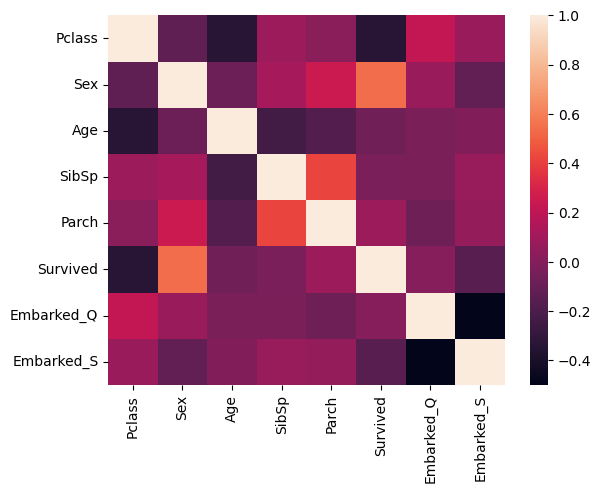

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(df.corr())
plt.show()

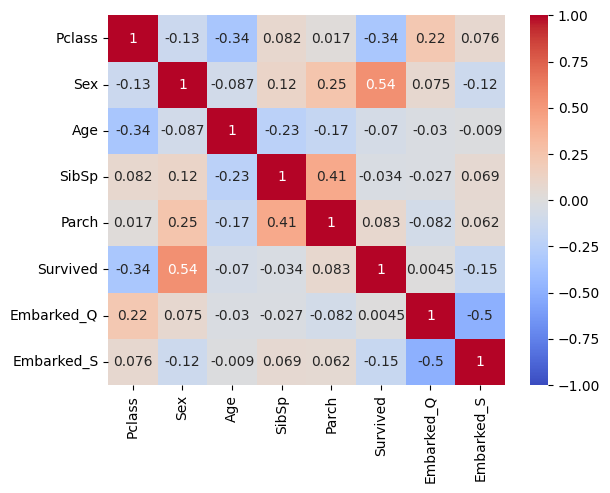

In [8]:
sns.heatmap(df.corr(), cmap = 'coolwarm', vmin = -1, vmax = 1, annot = True)
plt.show()

Data Preprocessing

In [9]:
df = pd.read_csv('https://media.githubusercontent.com/media/musthave-ML10/data_source/main/titanic.csv')
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Embarked,Survived
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,S,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,C,1
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,S,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,S,1
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,S,0


In [10]:
df.drop(['Name', 'Ticket'], axis = 1, inplace = True)
df.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked,Survived
0,3,male,22.0,1,0,S,0
1,1,female,38.0,1,0,C,1
2,3,female,26.0,0,0,S,1
3,1,female,35.0,1,0,S,1
4,3,male,35.0,0,0,S,0


In [11]:
df = pd.get_dummies(df, columns = ['Sex', 'Embarked'], drop_first = True)
df.head()

,Pclass,Age,SibSp,Parch,Survived,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,0,True,False,True
1,1,38.0,1,0,1,False,False,False
2,3,26.0,0,0,1,False,False,True
3,1,35.0,1,0,1,False,False,True
4,3,35.0,0,0,0,True,False,True


In [12]:
from sklearn.model_selection import train_test_split
X = df.drop('Survived', axis = 1)
y = df.Survived
xtr,xt, ytr, yt = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [13]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(xtr, ytr)
pred = lr.predict(xt)

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(yt, pred)

0.7808988764044944

In [15]:
lr.coef_

array([[-1.18234354, -0.03991188, -0.32140308,  0.00730054, -2.56910288,
        -0.07696271, -0.23548312]])

In [16]:
pd.Series(lr.coef_[0], index = X.columns)

,0
Pclass,-1.182344
Age,-0.039912
SibSp,-0.321403
Parch,0.007301
Sex_male,-2.569103
Embarked_Q,-0.076963
Embarked_S,-0.235483


In [ ]:
# During feature engineering, the heatmap revealed a noticeable correlation between SibSp (number of siblings / spouses aboard) and Parch (number of parents / children aboard).
# Because both variables essentially describe a passenger’s family members, we will merge them into a single feature—Family—to capture total family size (e.g., Family = SibSp + Parch).

In [17]:
df['family'] = df.SibSp + df.Parch
df.drop(['SibSp', 'Parch'], axis = 1, inplace = True)
df.head()

,Pclass,Age,Survived,Sex_male,Embarked_Q,Embarked_S,family
0,3,22.0,0,True,False,True,1
1,1,38.0,1,False,False,False,1
2,3,26.0,1,False,False,True,0
3,1,35.0,1,False,False,True,1
4,3,35.0,0,True,False,True,0


In [18]:
X = df.drop('Survived', axis = 1)
y = df.Survived
xtr,xt,ytr,yt = train_test_split(X, y, test_size = 0.2, random_state = 100)
lr.fit(xtr,ytr)
pred = lr.predict(xt)
accuracy_score(yt, pred)

0.7921348314606742

In [ ]:
# I confirmed that adding the new "Family" feature yields a slight improvement in the model's predictive performance.